In [130]:
## Text Mining Project
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import lyricsgenius
import time
import spacy
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models import LdaModel
import logging
from gensim.models import CoherenceModel
from operator import itemgetter
from collections import Counter

In [68]:
all_artists = ['187 Strassenbande', 'AK Ausserkontrolle', 'Alligatoah', 'Apache 207', 'Azad', 'Azet', 'badmómzjay', 'Bausa', 'Beginner', 'Bonez MC', 'Bushido', 'Capital Bra', 'Casper', 'Celo & Abdi', 'Chakuza', 'Cro', 'Culcha Candela', 'CÉLINE', 'Dardan', 'Deichkind', 'Die Atzen', 'Die Fantastischen Vier', 'Eko Fresh', 'Eno', 'Farid Bang', 'Fero47', 'Fettes Brot', 'Fler', 'Freundeskreis', 'Genetikk', 'Gzuz', 'Haftbefehl', 'Jamule', 'Jan Delay', 'Joker Bra', 'Juju', 'K.I.Z', 'KC Rebell', 'Kay One', 'Kollegah', 'Kontra K', 'Kool Savas', 'Kraftklub', 'Loredana', 'Luciano', 'MERO', 'Marteria', 'Max Herre', 'MoTrip', 'Money Boy', 'Moses Pelham', 'Nimo', 'Olexesh', 'Peter Fox', 'Prinz Pi', 'RAF Camora', 'RIN', 'Rödelheim Hartreim Projekt', 'SSIO', 'SXTN', 'Sabrina Setlur', 'Samra', 'Samy Deluxe', 'Seeed', 'Shindy', 'Sido', 'Silla', 'Summer Cem', 'Tic Tac Toe', 'Trailerpark', 'Trettmann', 'Ufo361', 'Veysel', 'XATAR', 'Xavas', 'Yung Hurn', 'Zuna']

In [100]:
# Genius token - https://genius.com/api-clients
# Library - https://github.com/johnwmillr/LyricsGenius
token = "KbIhkIUKtt6IqQnUWh7KwZXWU8d-FduTSQfCnJWHQh97BVs07PisfSWIYs0uAwX6"
genius = lyricsgenius.Genius(token)

In [3]:
# Download the lyrics
for artist_name in all_artists:
    try:
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()
    except:
        time.sleep(300)
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()

In [69]:
# Store lyrics and relevant metadata in dataframe
all_songs = pd.DataFrame(columns = ['Title', 'Artist', 'Release', 'Lyrics'])

for artist_name in all_artists:
    print(artist_name)
    # Extract data from the json files
    with open(f'Lyrics_{artist_name.replace(" ", "").replace("&", "")}.json') as json_file:
        data = json.load(json_file)
        for song in data['songs']:
            title = song['title']
            release = song['release_date']
            lyrics_raw_raw = song['lyrics']
            # Exclude songs without lyrics or release date, songs that contain brackets () and commentaries
            if lyrics_raw_raw != None and release != None and not re.search(' \(.*?\)', title) and 'Commentary' not in title:
                # Remove line breaks from lyrics
                lyrics_raw = lyrics_raw_raw.replace('\n', ' ')
                # Remove brackets from the lyrics, as they only contain meta info and calls e.g. [Hook], (yeah!)                
                lyrics = re.sub("[\[].*?[\]]|[\(].*?[\)]", "", lyrics_raw)
                # Filter lyrics with english parts by best effort
                if not re.search('(?=.* the )(?=.* you )(?=.* and )', lyrics):
                    new_song = {'Title': title, 'Artist': artist_name, 'Release': release, 'Lyrics': lyrics}
                    all_songs = all_songs.append(new_song, ignore_index=True)

187 Strassenbande
AK Ausserkontrolle
Alligatoah
Apache 207
Azad
Azet
badmómzjay
Bausa
Beginner
Bonez MC
Bushido
Capital Bra
Casper
Celo & Abdi
Chakuza
Cro
Culcha Candela
CÉLINE
Dardan
Deichkind
Die Atzen
Die Fantastischen Vier
Eko Fresh
Eno
Farid Bang
Fero47
Fettes Brot
Fler
Freundeskreis
Genetikk
Gzuz
Haftbefehl
Jamule
Jan Delay
Joker Bra
Juju
K.I.Z
KC Rebell
Kay One
Kollegah
Kontra K
Kool Savas
Kraftklub
Loredana
Luciano
MERO
Marteria
Max Herre
MoTrip
Money Boy
Moses Pelham
Nimo
Olexesh
Peter Fox
Prinz Pi
RAF Camora
RIN
Rödelheim Hartreim Projekt
SSIO
SXTN
Sabrina Setlur
Samra
Samy Deluxe
Seeed
Shindy
Sido
Silla
Summer Cem
Tic Tac Toe
Trailerpark
Trettmann
Ufo361
Veysel
XATAR
Xavas
Yung Hurn
Zuna


In [34]:
#print(test_frame[test_frame['Release'].isnull()])
#print(all_songs[all_songs['Title'].str.contains(' \(.*?\)')])
#print(all_songs[all_songs['Artist']=='Bushido'])
#print(all_songs.iloc[8]['Lyrics'])
#print(all_songs.head())

In [4]:
nlp = spacy.load('de_core_news_lg')
nlp_en = spacy.load('en')

In [73]:
# Preprocessing
docs = []

print('Tokenization')
# Tokenization and Lemmatization (remove stop words, numbers and one/two character words)
for index, song in all_songs.iterrows():
    # Remove the artist name from the lyrics
    doc = nlp(song['Lyrics'].replace(song['Artist'],''))
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs.append(lemmatized_doc)

# Remove english stop words
en_stop_words = nlp_en.Defaults.stop_words
docs = [[word for word in doc if not word.lower() in en_stop_words] for doc in docs]

print('Adding bigrams/trigrams')
# Add bigrams/trigrams that appear 5 times or more (texts are short)
bigram = Phrases(docs, min_count=5)
trigram = Phrases(bigram[docs], min_count=5)

for idx in range(len(docs)):
    for token in trigram[bigram[docs[idx]]]:
        if '_' in token:
            docs[idx].append(token)
    
print('Filtering extremes')
# Filter extremes, these values seem to work well
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=20, no_above=0.5)

print('Compute BoW representation')
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]

temp = dictionary[0]
id2word = dictionary.id2token

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Tokenization
Adding bigrams/trigrams
Filtering extremes
Compute BoW representation
Number of unique tokens: 6483
Number of documents: 7490


In [6]:
def plot_passes(filename, passes):
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open(filename) as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    plt.plot(np.arange(0,passes,1), likelihoods, c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("pass")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.show()

In [7]:
def create_logfile(filename):
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename,
                        format="%(asctime)s:%(levelname)s:%(message)s",
                        level=logging.INFO)

In [9]:
def get_coherence_score(lda_model):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [11]:
chunksize = 1000
passes = 100
iterations = 1000
random_state = 973525

model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
topics_range = range(4, 16)
alpha = [0.01, 1, 0.3, 'auto']
beta = [0.01, 1, 0.3, 'auto']

for t in topics_range:
    for a in alpha:
        for b in beta:  
            lda_model = LdaModel(
                     corpus=corpus,
                     id2word=id2word,
                     num_topics=t,
                     passes=passes,
                     iterations=iterations,
                     chunksize=chunksize,
                     alpha=a,
                     eta=b,
                     random_state=random_state
            )
            cv = get_coherence_score(lda_model)
            model_results['Topics'].append(t)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print(cv)

0.37691659053048826
0.3695009499499139
0.3665327989918461
0.3761930813043311
0.39815238952303156
0.38443024866251596
0.39160474642506005
0.39160474642506005
0.3952819672077284
0.3702783264512026
0.37680492763761525
0.3931130123028727
0.39984035232602927
0.37222250415287095
0.3960652268431284
0.39998455657124815
0.39770553659642827
0.3869412443372419
0.39122702577152213
0.39586869501651833
0.41112808965061787
0.3986850171366002
0.4013425947849667
0.40777651558877964
0.40887835975156744
0.3899337533913515
0.3929713095525587
0.4039780920588373
0.41067768773471397
0.38649668862796766
0.39620616322401225
0.40846021873623106
0.3951992646765572
0.39092910473934944
0.391726984942544
0.3931335976023817
0.39988131612646827
0.40542772883974365
0.4075097693031786
0.41127133427965495
0.3970112227343236
0.39755484758985915
0.4070264812961573
0.40223596536971357
0.41542572725074384
0.38907505985511825
0.40081933978430623
0.4083120628354952
0.3982506062723865
0.3950503340463105
0.40514638048223856
0.4

In [20]:
index, element = max(enumerate(model_results['Coherence']), key=itemgetter(1))

print(model_results['Topics'][index])
print(model_results['Alpha'][index])
print(model_results['Beta'][index])
print(model_results['Coherence'][index])

10
auto
auto
0.4574865803627299


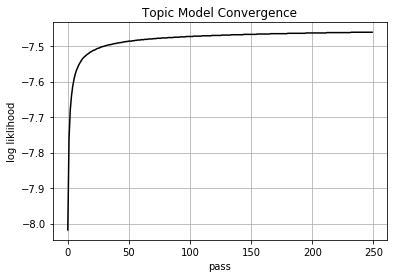

10 Topics:


[(0,
  '0.022*"Leben" + 0.016*"Welt" + 0.012*"sehen" + 0.011*"bleiben" + 0.009*"weiß" + 0.009*"Gott" + 0.008*"Herz" + 0.008*"lieben" + 0.008*"Auge" + 0.007*"Weg" + 0.007*"Mensch" + 0.007*"leben" + 0.007*"Traum" + 0.006*"tun" + 0.005*"Nacht" + 0.005*"seh" + 0.005*"sterben" + 0.005*"Licht" + 0.005*"Kopf" + 0.004*"glauben"'),
 (1,
  '0.032*"mal" + 0.013*"Mann" + 0.011*"sagen" + 0.011*"eine" + 0.009*"Frau" + 0.009*"mach" + 0.009*"einfach" + 0.008*"stehen" + 0.007*"denken" + 0.007*"Leute" + 0.007*"fragen" + 0.006*"sag" + 0.006*"nix" + 0.006*"weg" + 0.006*"Haus" + 0.006*"wär" + 0.006*"sehen" + 0.006*"nich" + 0.006*"ein" + 0.006*"drauf"'),
 (2,
  '0.090*"Baby" + 0.033*"komm" + 0.032*"weiß" + 0.030*"lieben" + 0.020*"Komm" + 0.020*"bitte" + 0.019*"sag" + 0.018*"Nacht" + 0.016*"zieh" + 0.015*"Sag" + 0.014*"lass" + 0.014*"wissen" + 0.012*"Babe" + 0.012*"Club" + 0.012*"Bitte" + 0.010*"fühlen" + 0.009*"Party" + 0.009*"vorbei" + 0.009*"tanzen" + 0.008*"geben"'),
 (3,
  '0.076*"Bitch" + 0.067*"yeah" 

In [23]:
filename = 'gensim_11.log'
create_logfile(filename)

num_topics = 10
chunksize = 1000
passes = 250
iterations = 10000
random_state = 973525


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics(num_words=20)

In [44]:
print(get_coherence_score(lda_model))

0.4534791872810759


In [98]:
num_topics = 5
chunksize = 1000
passes = 250
iterations = 1000
random_state = 8

lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model))
lda_model.print_topics(num_words=20)

5 Topics:
0.4146591477974124


[(0,
  '0.011*"Bruder" + 0.011*"Geld" + 0.008*"mach" + 0.007*"Straße" + 0.006*"Benz" + 0.005*"Kopf" + 0.005*"Jungs" + 0.005*"Block" + 0.005*"Gang" + 0.005*"Bra" + 0.005*"eine" + 0.005*"Scheine" + 0.004*"geben" + 0.004*"Para" + 0.004*"weg" + 0.004*"Digga" + 0.004*"voll" + 0.004*"Fick" + 0.004*"paar" + 0.004*"Bratan"'),
 (1,
  '0.013*"Leben" + 0.009*"Welt" + 0.008*"sehen" + 0.008*"mal" + 0.007*"weiß" + 0.007*"bleiben" + 0.006*"lieben" + 0.005*"stehen" + 0.005*"Weg" + 0.005*"denken" + 0.005*"Gott" + 0.005*"Mann" + 0.005*"Herz" + 0.005*"Auge" + 0.005*"einfach" + 0.004*"Hand" + 0.004*"sagen" + 0.004*"weg" + 0.004*"Kopf" + 0.004*"leben"'),
 (2,
  '0.042*"Bitch" + 0.033*"yeah" + 0.020*"Money" + 0.019*"Bitches" + 0.018*"Yeah" + 0.013*"Geld" + 0.011*"ein" + 0.009*"eine" + 0.009*"Gucci" + 0.009*"Ice" + 0.009*"Cash" + 0.009*"Boss" + 0.008*"Boy" + 0.007*"Guck" + 0.006*"Louis" + 0.005*"like" + 0.005*"Hoes" + 0.005*"money" + 0.005*"Kette" + 0.005*"bang"'),
 (3,
  '0.010*"mal" + 0.010*"Rapper" + 0.00

In [321]:
def get_topic_from_song(model, title, artist=''):
    if artist == '':
        doc = docs[all_songs.index[all_songs['Title']==title][0]]
    else:
        song = genius.search_song(title, artist=artist)
        doc = preprocess_song(song.lyrics, artist)
        
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = model[song_corpus]
    topic = max(prob_distribution,key=itemgetter(1))[0]
    
    return topic

def get_topic_dist_from_song(model, title, artist=''):
    if artist == '':
        doc = docs[all_songs.index[all_songs['Title']==title][0]]
    else:
        song = genius.search_song(title, artist=artist)
        doc = preprocess_song(song.lyrics, artist)
        
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = model[song_corpus]
    
    return prob_distribution

In [103]:
def preprocess_song(lyrics, artist):
    docs_ = []
    doc = nlp(lyrics.replace(artist,''))
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs_.append(lemmatized_doc)

    en_stop_words = nlp_en.Defaults.stop_words
    docs_ = [[word for word in doc if not word.lower() in en_stop_words] for doc in docs_]

    bigram = Phrases(docs_, min_count=5)
    trigram = Phrases(bigram[docs_], min_count=5)

    for idx in range(len(docs_)):
        for token in trigram[bigram[docs_[idx]]]:
            if '_' in token:
                docs_[idx].append(token)
    
    return docs_[0]

In [312]:
pred = []
for index, song in all_songs.iterrows():
    pred.append(get_topic_from_song(lda_model, song['Title']))

In [131]:
Counter(pred)

Counter({'Kriminalität': 1296,
         'Leben & Lieben': 3080,
         'Rap': 2396,
         'Sex & Party': 351,
         'Status': 367})

In [136]:
num_topics = 6
chunksize = 1000
passes = 200
iterations = 1000
random_state = 8

lda_model_6 = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

print(f'{num_topics} Topics:')
print(get_coherence_score(lda_model_6))
lda_model_6.print_topics(num_words=40)

6 Topics:
0.416375781914235


[(0,
  '0.013*"Geld" + 0.011*"Bruder" + 0.008*"mach" + 0.006*"Straße" + 0.006*"Benz" + 0.006*"eine" + 0.006*"Gang" + 0.005*"Scheine" + 0.005*"Jungs" + 0.005*"geben" + 0.005*"Block" + 0.005*"Bra" + 0.004*"Kopf" + 0.004*"voll" + 0.004*"weg" + 0.004*"Digga" + 0.004*"paar" + 0.004*"Para" + 0.004*"Fick" + 0.004*"Mach"'),
 (1,
  '0.021*"Leben" + 0.014*"Welt" + 0.010*"sehen" + 0.010*"bleiben" + 0.009*"Weg" + 0.008*"Gott" + 0.008*"Herz" + 0.008*"Auge" + 0.007*"Hand" + 0.007*"Kopf" + 0.007*"leben" + 0.006*"stehen" + 0.006*"Mensch" + 0.006*"Nacht" + 0.006*"Traum" + 0.005*"sterben" + 0.005*"liegen" + 0.004*"Licht" + 0.004*"Bruder" + 0.004*"mein"'),
 (2,
  '0.064*"Bitch" + 0.052*"yeah" + 0.029*"Yeah" + 0.029*"Money" + 0.026*"Bitches" + 0.015*"Boss" + 0.013*"ein" + 0.013*"Geld" + 0.012*"Gucci" + 0.011*"Boy" + 0.010*"zieh" + 0.010*"eine" + 0.010*"Cash" + 0.009*"Guck" + 0.008*"Hoes" + 0.008*"flieg" + 0.007*"Kid" + 0.007*"bang" + 0.007*"hol" + 0.007*"Bang"'),
 (3,
  '0.013*"Rapper" + 0.011*"Rap" + 0.0

In [159]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_6, corpus, dictionary)
LDAvis_prepared

/home/luca/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.043238 -0.080539       1        1  24.137993
5      0.145600  0.014318       2        1  23.940693
1      0.212291 -0.100376       3        1  23.328171
0      0.038428 -0.034142       4        1  18.871731
4     -0.082095  0.347808       5        1   5.295849
2     -0.357463 -0.147069       6        1   4.425562, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
142   Default  3719.000000     Baby  3719.000000  30.0000  30.0000
434   Default  3446.000000    Bitch  3446.000000  29.0000  29.0000
655   Default  2914.000000     yeah  2914.000000  28.0000  28.0000
615   Default  2593.000000     Yeah  2593.000000  27.0000  27.0000
161   Default  5547.000000    Leben  5547.000000  26.0000  26.0000
106   Default  4499.000000     komm  4499.000000  25.0000  25.0000
724   Default  1784.000000    Dicka  1784.000000  24.0000  24.0000
113   Default  7712.000000      mal  7712.000000  23.0000  23.0000
427   Default  4874.000000     weiß  4874.000000  22.0000  22.0000
229   Default  4539.000000     Geld  4539.000000  21.0000  21.0000
264   Default  3669.000000     Welt  3669.000000  20.0000  20.0000
603   Default  3275.000000   Rapper  3275.000000  19.0000  19.0000
1445  Default  1648.000000  Bitches  1648.000000  18.0000  18.0000
1776  Default  1322.000000    Money  1322.000000  17.0000  17.0000
371   Default  2784.000000      Rap  2784.000000  16.0000  16.0000
159   Default  2263.000000     Komm  2263.000000  15.0000  15.0000
1137  Default  3284.000000   lieben  3284.000000  14.0000  14.0000
696   Default  3043.000000    sagen  3043.000000  13.0000  13.0000
324   Default  3297.000000   Bruder  3297.000000  12.0000  12.0000
46    Default  2638.000000    Nacht  2638.000000  11.0000  11.0000
271   Default  3251.000000      ein  3251.000000  10.0000  10.0000
187   Default  2577.000000  einfach  2577.000000   9.0000   9.0000
340   Default  2029.000000     Gott  2029.000000   8.0000   8.0000
592   Default  1929.000000     Herz  1929.000000   7.0000   7.0000
150   Default  1066.000000     Boss  1066.000000   6.0000   6.0000
589   Default  1987.000000     Guck  1987.000000   5.0000   5.0000
88    Default  4624.000000     eine  4624.000000   4.0000   4.0000
203   Default  2820.000000      sag  2820.000000   3.0000   3.0000
613   Default  2514.000000      Weg  2514.000000   2.0000   2.0000
108   Default  2815.000000     lass  2815.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
2570   Topic6    73.902847     Slut    74.728584   3.1067  -6.4396
434    Topic6  2958.317139    Bitch  3446.021484   2.9652  -2.7500
655    Topic6  2410.935059     yeah  2914.238281   2.9282  -2.9546
3173   Topic6   567.674133    Gucci   641.920044   2.9949  -4.4008
4631   Topic6   350.788574     Hoes   396.216064   2.9960  -4.8822
2848   Topic6   199.007538   ballen   216.697250   3.0326  -5.4490
1445   Topic6  1215.858765  Bitches  1648.520264   2.8133  -3.6391
3022   Topic6   337.922424     bang   417.965759   2.9052  -4.9195
2241   Topic6   500.867981      Boy   688.098022   2.8002  -4.5260
3295   Topic6   300.350647     Dick   383.261536   2.8740  -5.0374
150    Topic6   680.054688     Boss  1066.608398   2.6677  -4.2202
1531   Topic6   348.385345    flieg   472.240814   2.8136  -4.8890
615    Topic6  1352.086304     Yeah  2593.716553   2.4663  -3.5330
3021   Topic6   301.147430     Bang   404.700989   2.8222  -5.0348
3829   Topic6   246.073608      hey   328.337097   2.8294  -5.2367
4146   Topic6   257.557587      Gun   366.010803   2.7664  -5.1911
2127   Topic6   203.027328      BMW   286.769409   2.7724  -5.4290
4      Topic6   470.705109     Cash  1077.244629   2.2898  -4.5881
1037   Topic6   225.290558    Pussy   339.097473   2.7089  -5.3250
709    Topic6   484.153839     zieh  1202

In [310]:
def performance_test_known(model):
    pred_ = np.array([])
    wrong_labeled = []
    wrong_labeled_2 = []
    wrong_labeled_3 = []
    test_songs = ['Flow', 'Das ist für die Diebe', 'Zwiespalt', 'Sex mit dir', 'Action Muzik', 'Nike Pullover', 'Zirkus', 'Was Du Liebe nennst',
                  'Hip Hop muss am Leben bleiben', 'Party von uns', 'Zukunft', 'Zeit vergeht', 'Verflossene Liebe', 'Durchsuchungsbefehl',
                  'Welt In Flammen', 'Du', 'Versace', 'Tränen aus Kajal', 'Kripos jagen mich', 'Party 2', 'Das Geht Ab', 'Affen mit Waffen',
                  'Wenn sein Album kommt', 'Kopfgeld', 'Sie will es', 'Money', 'An Tagen wie diesen', 'Wenn ich kein Rapper wär', 'Pulsschlag',
                  'BITCHES', 'Kriminell', 'Mann im Spiegel', 'Nachtaktiv', 'Liebe', 'Gucci Pulli L', 'Hi Babe', 'Fremdgehen', 'Waffenarsenal',
                  'Style & das Geld', 'Alpha', 'Blei', 'Warum rappst Du?', 'Kein Liebeslied', 'MILLIONDOLLAR$MILE', 'Roli', 'Mermi Flow',
                  'OMG!', 'Hallo Welt!', 'Wenn du mich liebst', 'Ballen wie die Lakers', 'Hartreim Saga', 'Vollautomatik', 'Zu high', 
                  'Haus am See', 'Laura', 'Waffen', 'Dior 2001', 'Dieses Lied', 'Hash Hash', 'Von Party zu Party', 'Du Liebst Mich Nicht',
                  'Gott bietet mehr', 'Vater im Himmel', 'G€LD', 'Babygirl', 'Herz', 'Mainstream', 'Casanova', 'Isch liebe disch', 
                  'Deutscher Rapslum', 'Skyline', '1000 Bitches', 'Bam Bam', 'Lebe dein Leben', 'Wo sind sie jetzt', 'Pillen', 'Volles Magazin']
    test_label = np.array([3, 0, 1, 4, 3, 0, 3, 5, 3, 4, 3, 1, 5, 0, 3, 5, 2, 5, 0, 4, 4, 1, 3, 0, 4, 2, 1, 1, 3, 2, 0, 1, 4, 5, 2, 4, 5, 0, 2, 3, 0, 
                  3, 5, 2, 2, 3, 1, 1, 5, 2, 3, 0, 4, 1, 5, 0, 4, 1, 3, 4, 5, 1, 1, 2, 5, 1, 3, 4, 5, 3, 1, 2, 0, 1, 1, 4, 0])
    for i, song_title in enumerate(test_songs):
        pred_ = np.append(pred_, get_topic_from_song(model, song_title))
        if pred_[i] != test_label[i]:
            wrong_labeled.append((pred_[i], test_label[i]))
            wrong_labeled_2.append(pred_[i])
            wrong_labeled_3.append(test_label[i])
    correct_predictions = (pred_ == test_label).sum()
    print(f'Predicted {correct_predictions} of {len(test_label)} ({int(correct_predictions/len(test_label)*100)}%)')
    print(f'Incorrect labeling pairs: {Counter(wrong_labeled)}')
    print(f'Incorrect predictions: {Counter(wrong_labeled_2)}')
    print(f'Incorrectly predicted labels: {Counter(wrong_labeled_3)}')

In [311]:
performance_test_known(lda_model_6)

Predicted 45 of 77 (58%)
Incorrect labeling pairs: Counter({(0.0, 2): 5, (1.0, 5): 4, (5.0, 1): 4, (5.0, 4): 3, (5.0, 3): 3, (1.0, 4): 2, (3.0, 0): 2, (0.0, 3): 2, (3.0, 4): 1, (5.0, 2): 1, (1.0, 0): 1, (3.0, 2): 1, (0.0, 5): 1, (0.0, 4): 1, (4.0, 2): 1})
Incorrect predictions: Counter({5.0: 11, 0.0: 9, 1.0: 7, 3.0: 4, 4.0: 1})
Incorrectly predicted labels: Counter({2: 8, 4: 7, 5: 5, 3: 5, 1: 4, 0: 3})


In [314]:
all_songs['Label'] = pred

In [319]:
all_songs['Release'] = all_songs['Release'].map(lambda date: date[:-6])

In [ ]:
topic_dists = {
'topic_0': [],
'topic_1': [],
'topic_2': [],
'topic_3': [],
'topic_4': [],
'topic_5': []}

for index, song in all_songs.iterrows():
    dist_ = get_topic_dist_from_song(lda_model_6, song['Title'])
    
    for i in range(0,6):
        try:
            topic, prob = dist_[i]
            if i != topic:
                dist_.insert(i, (i, 0.0))
        except:
            dist_.append((i, 0.0))

    for (topic, prob) in dist_:
        topic_dists[f'topic_{topic}'].append(prob)

In [332]:
all_songs['Street'] = topic_dists['topic_0']
all_songs['Life'] = topic_dists['topic_1']
all_songs['Swag'] = topic_dists['topic_2']
all_songs['Competition'] = topic_dists['topic_3']
all_songs['Sex & Party'] = topic_dists['topic_4']
all_songs['Love'] = topic_dists['topic_5']

In [335]:
all_songs

,Title,Artist,Release,Lyrics,Label,Street,Life,Swag,Competition,Sex & Party,Love
0,100er Batzen,187 Strassenbande,2017,"Ich brauch' Hunderterbatzen, Klunker um'n Nac...",0,0.538018,0.095768,0.000000,0.168376,0.000000,0.195663
1,100k,187 Strassenbande,2017,"Wir sind gekomm'n, um zu bleiben und keiner w...",1,0.370120,0.133590,0.000000,0.027750,0.050942,0.416682
2,10 Dinger,187 Strassenbande,2017,"Ich schwör' dir, wenn ich mal Kohle mache, da...",0,0.558180,0.086212,0.000000,0.119347,0.086173,0.148736
3,10 Jahre,187 Strassenbande,2016,"Daimler frisiert, zweimal foliert Gazi hat an...",0,0.415939,0.133639,0.000000,0.165930,0.000000,0.282594
4,24/7,187 Strassenbande,2017,"Seite mit Messer, gleic h geht's mir besser T...",0,0.520692,0.121543,0.022988,0.166451,0.000000,0.166180
5,30er Zone,187 Strassenbande,2017,"Dreiunddreißig Grad, lass die Chromfelge au...",0,0.640732,0.133389,0.000000,0.109621,0.073763,0.041319
6,95 - 09,187 Strassenbande,2009,"""... du bist ein Rapper!"" ’96: Snoop Doggy ...",3,0.013105,0.123185,0.046579,0.472978,0.130117,0.214036
7,Alles ist entspannt,187 Strassenbande,2011,Bring mein Namen an die Wand! Ich zieh es ...,1,0.296334,0.291437,0.000000,0.137024,0.000000,0.271550
8,Allstars 2017,187 Strassenbande,2017,"Sa zu der 4, zu oft totgeschwiegen Bezahl' di...",0,0.446703,0.091890,0.000000,0.267269,0.017881,0.175668
9,Auf der Jagd nach Papier,187 Strassenbande,2011,Jetzt werde ich euch Strichern mal was zeigen...,0,0.461520,0.259200,0.000000,0.073582,0.027832,0.176801
